## 1. Downloading Dataset

In [ ]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle

import os, json

kaggle_json = {
    "username": os.getenv("KAGGLE_USERNAME"),
    "key": os.getenv("KAGGLE_PASS")
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_json, f)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud -p ./data
!unzip -o ./data/creditcardfraud.zip -d ./data

zip_path = "./data/creditcardfraud.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/creditcardfraud.zip
  inflating: ./data/creditcard.csv   


## 2. Libraries and Configurations

In [19]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

# Configurations
pd.set_option('display.max_columns',None) # exibir todas as colunas do meu df
pd.set_option("display.max_seq_items", None) # exibir todas as linhas no meu for

## 3. Understanding the Problem
----
This project aims to develop a **Machine Learning model** to classify credit card transactions as legitimate or fraudulent, using a publicly available dataset from Kaggle.

The choice of a Logistic Regression model comes from the content learned in the course, where we saw that this type of model is very effective for solving classification problems with relatively simple steps.


### **3.1. Motivation**

----

**1. Professional experience:**

I currently work in the banking sector, where fraud is a recurring challenge. This professional background motivated me to choose credit card fraud detection as the topic for my first project.

**2. Real-world problem:**

Credit card fraud is a common problem in real life. Therefore, working on this project provides valuable insights and practical challenges to apply the concepts learned during the first part of the course.

### **3.2. Objectives**

----

- Build a predictive model capable of classifying transactions as fraudulent or not.
- Evaluate performance using concepts from the Evaluation chapter and select the most appropriate metrics.
- Interpret the results and identify the main factors that increase the probability of fraudulent transactions.

## 4. Dataset Informations
----
The dataset used in this project is Credit Card Fraud Detection (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data), which contains credit card transactions carried out by European cardholders in September 2013.

To protect customer privacy and sensitive information, most features have been anonymized and transformed using PCA, resulting in a dataset suitable for research with real-world data.

### **4.1. Features Description:**

----

- **Time:** Number of seconds elapsed between this transaction and the first transaction in the dataset.
- **V1 - V28:** Result of PCA transformation, used to anomyze original features realted to customers and transactions.
- **Amount:** Transaction amount.
- **Class:** Target variable – 1 for fraud, 0 for legitimate transactions.

### **4.2. Dataset Characteristics:**

----

- The dataset contains 284.807 transactions, of which 492 are fraudulent (~0,17%).
- The main challenge is the highly imbalanced nature of the dataset, which reflects a common real-world problem in fraud detection.
- The anonymization through PCA limits the interpretability of the features, but this is acceptable for tackling a realistic problem.

## 5. Exploratory Data Analysis (EDA)
----

In [20]:
df = pd.read_csv('data/creditcard.csv')

In [23]:
df.shape

(284807, 31)

### 3. Data Preparation

In [55]:
# Dividindo em tipos de coluna:

categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = [col for col in df.dtypes[df.dtypes != 'object'].index if col not in ['reached_on_time_y_n', 'id']]

In [30]:
# Padronização das variáveis categóricas:
 
for i in categorical:
    df[i] = df[i].str.lower().str.strip().str.replace(" ","_").str.replace(".","_")

In [31]:
# Verificando valores nulos:

df.isnull().sum()

id                     0
warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
cost_of_the_product    0
prior_purchases        0
product_importance     0
gender                 0
discount_offered       0
weight_in_gms          0
reached_on_time_y_n    0
dtype: int64

In [32]:
df.head()

,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,reached_on_time_y_n
0,1,d,flight,4,2,177,3,low,f,44,1233,1
1,2,f,flight,4,5,216,2,low,m,59,3088,1
2,3,a,flight,2,2,183,4,low,m,48,3374,1
3,4,b,flight,3,3,176,4,medium,m,10,1177,1
4,5,c,flight,2,2,184,3,medium,f,46,2484,1


### 4. Setting up Validation Framework

In [ ]:
# Fazendo a divisão Train / Validation / Test >> 60 / 20 / 20
rs = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs) # 80/20
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs) # 25% de 80 >> 60/20/20

In [35]:
len(df), len(df_full_train), len(df_train), len(df_val), len(df_test)

(10999, 8799, 6599, 2200, 2200)

In [37]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
# Configurando a váriavel target como y:

y_full_train = df_full_train['reached_on_time_y_n']
y_train = df_train['reached_on_time_y_n']
y_val = df_val['reached_on_time_y_n']
y_test = df_test['reached_on_time_y_n']

In [41]:
# del df_full_train['reached_on_time_y_n']
del df_train['reached_on_time_y_n']
del df_val['reached_on_time_y_n']
del df_test['reached_on_time_y_n']

### 5. EDA: Exploratory Data Analysis

In [ ]:
# Verificação da taxa de atraso geral:

global_delay_rate = df_full_train['reached_on_time_y_n'].value_counts(normalize=True)[1]
round(global_delay_rate,3)

np.float64(0.598)

In [ ]:
# Verificação das categorias possíveis:

for i in categorical:
    print(f'{i:<18} | Total de categorias: {df_full_train[i].nunique()} | {df_full_train[i].unique()}')

warehouse_block    | Total de categorias: 5 | ['f' 'a' 'd' 'c' 'b']
mode_of_shipment   | Total de categorias: 3 | ['ship' 'flight' 'road']
product_importance | Total de categorias: 3 | ['low' 'medium' 'high']
gender             | Total de categorias: 2 | ['f' 'm']


In [ ]:
# Verificação da distribuição das variáveis numéricas:

for i in numerical:
    plt.figure(figsize=(5,3))
    sns.histplot(df[i])
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()           

### 5. Featuring Engineering


In [78]:
for i in categorical:
    diff = (df_full_train.groupby(i)['reached_on_time_y_n'].mean() / global_delay_rate - 1)
    print(f'{i}')
    for j in range(len(diff)):
            print(f'- {diff.index[j]:>6}: {diff.values[j].round(4):>7}')

warehouse_block
-      a: -0.0302
-      b:   0.014
-      c:  0.0098
-      d: -0.0108
-      f:  0.0088
mode_of_shipment
- flight:  0.0099
-   road: -0.0166
-   ship:  0.0015
product_importance
-   high:  0.0942
-    low: -0.0034
- medium: -0.0149
gender
-      f:  0.0021
-      m: -0.0021


In [81]:
for i in categorical:
    print(i)
    df_group_disp = df_full_train.groupby(i)['reached_on_time_y_n'].agg(['count','mean'])
    df_group_disp['mean'] = (df_group_disp['mean']*100).round(2)
    df_group_disp['diff_abs (%)'] = ((df_group_disp['mean'] - (global_delay_rate*100))).round(2)
    df_group_disp['risk_delay(%)'] = ((df_group_disp['mean'] / (global_delay_rate*100) - 1)*100).round(2)

    df_group_disp = df_group_disp.rename(columns={'mean': 'mean (%)'})
    
    df_group_disp = df_group_disp.reset_index()

    display(df_group_disp)
    print()


warehouse_block


,warehouse_block,count,mean (%),diff_abs (%),risk_delay(%)
0,a,1465,57.95,-1.81,-3.02
1,b,1454,60.59,0.83,1.39
2,c,1470,60.34,0.58,0.98
3,d,1487,59.11,-0.65,-1.08
4,f,2923,60.28,0.52,0.88



mode_of_shipment


,mode_of_shipment,count,mean (%),diff_abs (%),risk_delay(%)
0,flight,1425,60.35,0.59,0.99
1,road,1392,58.76,-1.00,-1.67
2,ship,5982,59.85,0.09,0.16



product_importance


,product_importance,count,mean (%),diff_abs (%),risk_delay(%)
0,high,754,65.38,5.62,9.41
1,low,4250,59.55,-0.21,-0.35
2,medium,3795,58.87,-0.89,-1.48



gender


,gender,count,mean (%),diff_abs (%),risk_delay(%)
0,f,4392,59.88,0.12,0.21
1,m,4407,59.63,-0.13,-0.21


### 6. Features Importance

In [ ]:
# Verificando a importância das Features categóricas:

mutual = {}
for i in categorical:
    a = round(mutual_info_score(df_full_train['reached_on_time_y_n'],df_full_train[i])*100,2)
    mutual[i] = a
df_mutual = pd.DataFrame(list(mutual.items()), columns=['feature', 'mutual_info (%)'])
df_mutual = df_mutual.sort_values(by="mutual_info (%)", ascending=False).reset_index(drop=True)
df_mutual

,feature,mutual_info (%)
0,product_importance,0.06
1,warehouse_block,0.02
2,mode_of_shipment,0.00
3,gender,0.00


customer_care_calls   -0.072117
customer_rating        0.011056
cost_of_the_product   -0.078052
prior_purchases       -0.060074
discount_offered       0.396499
weight_in_gms         -0.264249
dtype: float64

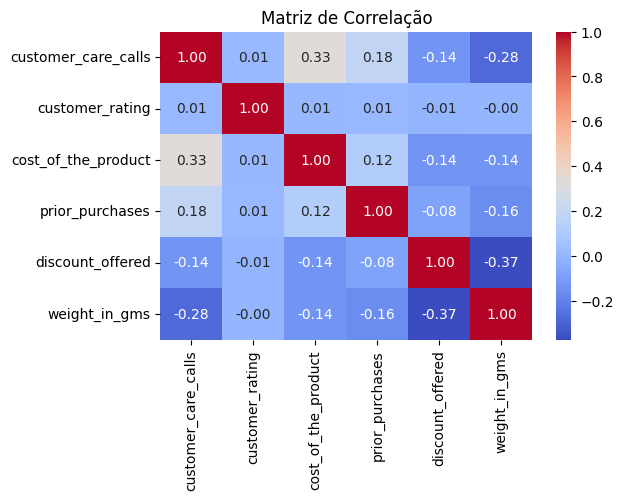

In [94]:
# Verificando a correlação entre as Features numéricas:

display(df_full_train[numerical].corrwith(df_full_train['reached_on_time_y_n']))

plt.figure(figsize=(6, 4))
sns.heatmap(df_full_train[numerical].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

### 7. One-Hot Encoding

In [96]:
# Utilizando o DictVetorizer para realizar o One-Hot das minhas variáveis:

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [ ]:
# Verificação do Encoding:

dv.fit(train_dicts)
list(dv.get_feature_names_out())

# 4 categóricas - OK
# 6 numéricas - OK

['cost_of_the_product',
 'customer_care_calls',
 'customer_rating',
 'discount_offered',
 'gender=f',
 'gender=m',
 'mode_of_shipment=flight',
 'mode_of_shipment=road',
 'mode_of_shipment=ship',
 'prior_purchases',
 'product_importance=high',
 'product_importance=low',
 'product_importance=medium',
 'warehouse_block=a',
 'warehouse_block=b',
 'warehouse_block=c',
 'warehouse_block=d',
 'warehouse_block=f',
 'weight_in_gms']

In [ ]:
# Aplicando o One-Hot aos meus DFs:

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [100]:
# Verificando as colunas:

X_train.shape, X_val.shape

((6599, 19), (2200, 19))